Looking at the 2m cadence TESS data from sector 31

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/5tb_storage1/cc_cet/tess/MAST_2020-12-21T2128/TESS/tess2020294194027-s0031-0000000337219837-0198-s/'

In [3]:
lcpath = glob.glob('{}*lc.fits'.format(path))[0]
lcpath

'/media/david/5tb_storage1/cc_cet/tess/MAST_2020-12-21T2128/TESS/tess2020294194027-s0031-0000000337219837-0198-s/tess2020294194027-s0031-0000000337219837-0198-s_lc.fits'

In [4]:
data = fits.getdata(lcpath,1)
data.names

['TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2']

In [5]:
t, f, e, q, bk = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY'], data['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
#fit = np.polyval((np.polyfit(t,f,2)), t)
#f = (f/fit)-1
#e = (e/fit)
#cut_mask = (bk < 1.1*np.median(bk))
lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_nans()#.remove_outliers(sigma=5)

<AxesSubplot:xlabel='Time', ylabel='Flux'>

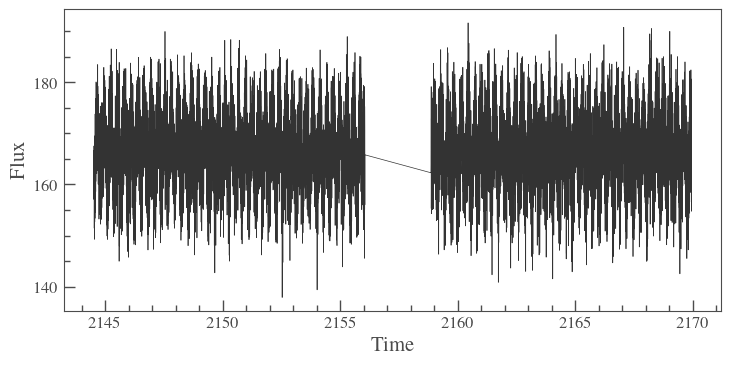

In [6]:
lc.plot()

In [7]:
pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=15*u.day)
#pg.plot()

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


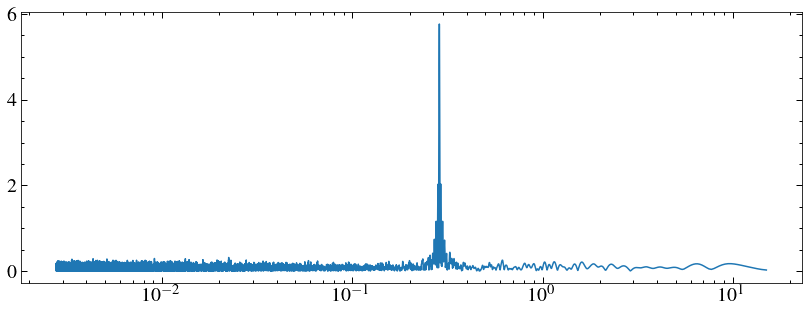

In [8]:
plt.plot(pg.period, pg.power)
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0.3, 1)

<AxesSubplot:xlabel='Phase', ylabel='Flux'>

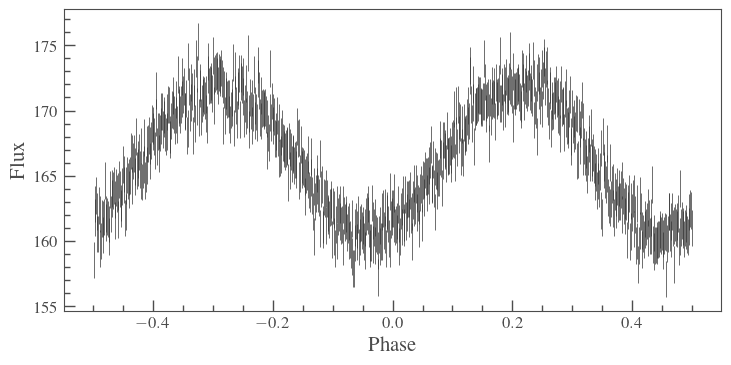

In [9]:
lc.fold(pg.period_at_max_power*2).bin(20).errorbar()

<AxesSubplot:xlabel='Time', ylabel='Flux [$\\mathrm{\\%}$]'>

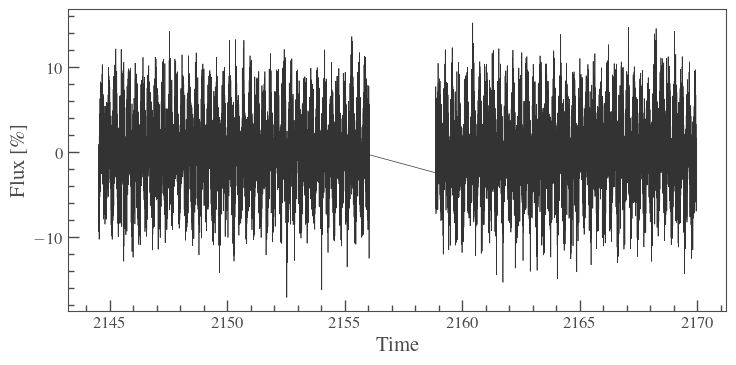

In [10]:
lc1 = lc.normalize(unit='percent')
lc1.flux -=100
lc1.plot()

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


3.4666049147608056 %


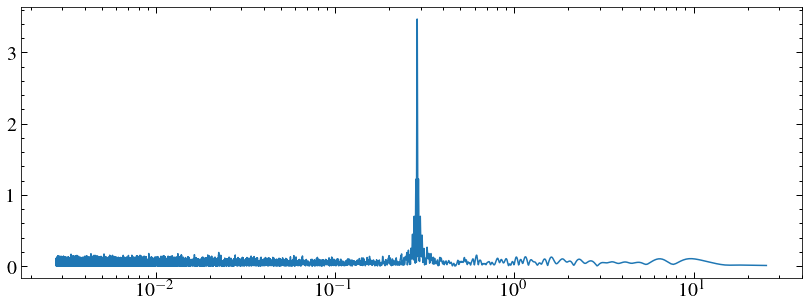

In [11]:
pg1 = lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=(lc.time[-1]-lc.time[0])*u.day)
plt.plot(pg1.period, pg1.power)
plt.xscale('log')
print(pg1.max_power)

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude          frequency            phase       
    ------------------ ------------------ ------------------
    -3.464159094295085 3.4874559464778145 1.2982676739155343
[3.88422195e-02 2.29364364e-04 4.94748586e-01]
Period = 6.881807359957909 0.0004526053927363888 h
Amplitude = -3.464159094295085 0.038842219463640075
Phase = 1.2982676739155343 0.4947485859182388


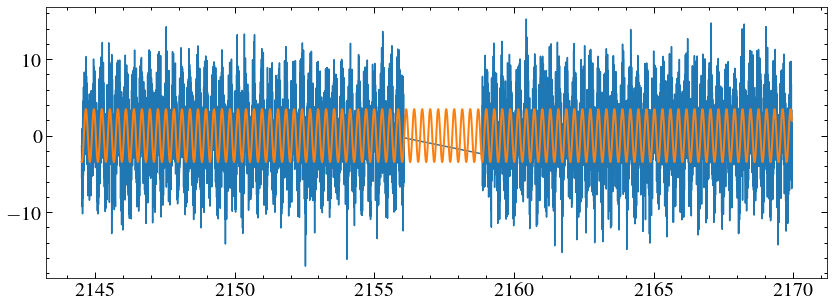

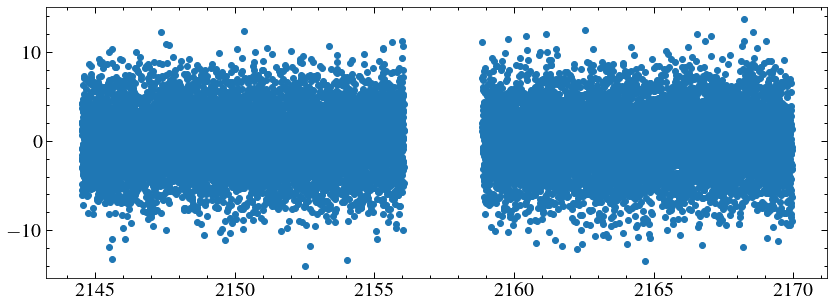

2144.8207783745556
Amplitude = 3.4641590955448995 0.03884099935534628
Phase = -0.20173230879196188 0.0017898689926790516
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      frequency        phase        
    ------------------ --------- --------------------
    3.4641590955448995       1.0 -0.20173230879196188
[0.038841   0.00178987]


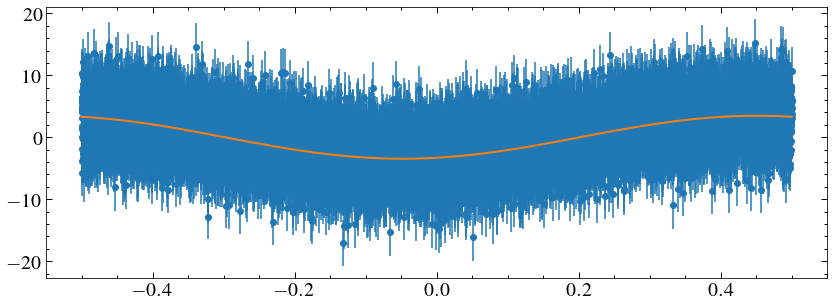

In [12]:
fitter = fitting.LevMarLSQFitter()


sin_mod =  models.Sine1D(amplitude=pg1.max_power.value, frequency= pg1.frequency_at_max_power.value, phase=0)#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
sin_fit = fitter(sin_mod, lc1.time, lc1.flux, weights = 1/lc1.flux_err, maxiter=100000)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc1.time, lc1.flux) 
timefit = np.linspace(lc1.time[0], lc1.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print(sin_fit)
print(sin_fit_e)
print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
print('Phase =', sin_fit.phase.value, sin_fit_e[2])
plt.show()
plt.scatter(lc1.time, lc1.flux-sin_fit(lc1.time))
plt.show()

t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.25)
print(t0)
lcf = lc1.fold(1/sin_fit.frequency.value)
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o')
fold_mod =  models.Sine1D(amplitude=pg1.max_power.value, frequency= 1, phase=0, fixed={'frequency':True})#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
fold_fit = fitter(fold_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
fold_time = np.linspace(-0.5, 0.5, 100)
plt.plot(fold_time, fold_fit(fold_time), c='C1', lw=2, zorder=10)

print('Amplitude =', fold_fit.amplitude.value, fold_fit_e[0])
print('Phase =', fold_fit.phase.value, fold_fit_e[1])
print(fold_fit)
print(fold_fit_e)

Phase error seems like nonsense so estimate it from the %age errors on the other two?

In [13]:
print(fold_fit_e[0]/abs(fold_fit.amplitude.value))
print(fold_fit_e[1]/fold_fit.frequency.value)
print(1/sin_fit.frequency.value*fold_fit_e[1])

0.011212244670083991
0.0017898689926790516
0.0005132305669657977


<AxesSubplot:xlabel='Time', ylabel='Flux'>

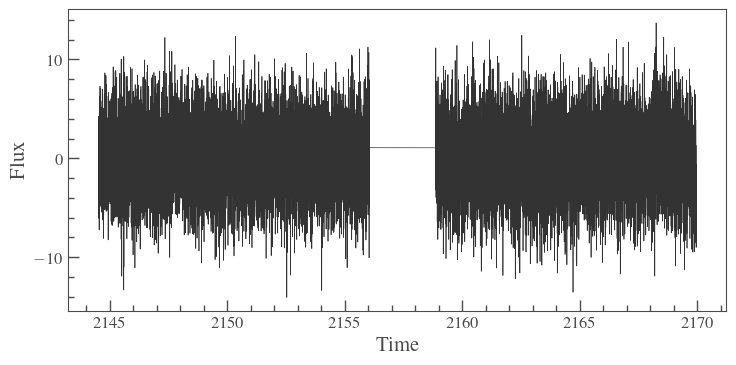

In [14]:
lc2 = lk.LightCurve(time=lc1.time, flux=lc1.flux-sin_fit(lc1.time), flux_err=lc1.flux_err )
#lc2.flux -= sin_fit(lc1.time)
lc2.plot()

32.27219294372088 min
0.19235838250633724


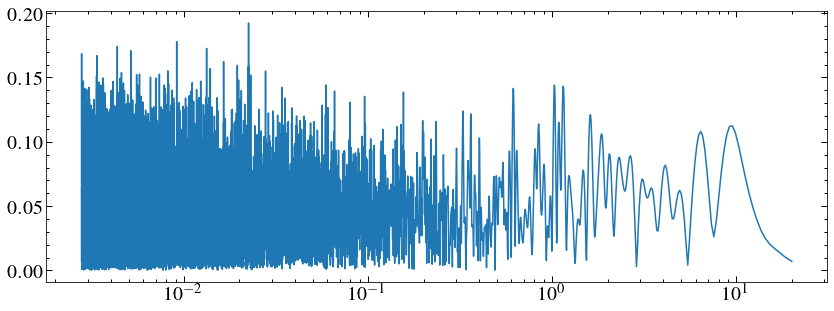

In [15]:
pg2 = lc2.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
plt.plot(pg2.period, pg2.power)
plt.xscale('log')
print(pg2.period_at_max_power.to(u.min))
print(pg2.max_power)

<AxesSubplot:xlabel='Phase', ylabel='Flux'>

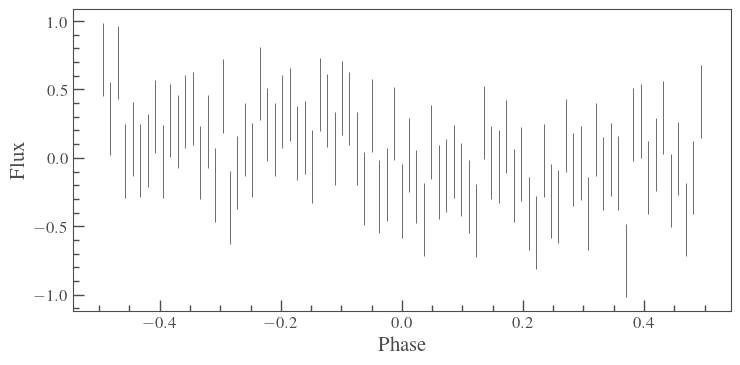

In [16]:
lc2.fold(pg2.period_at_max_power).bin(200).errorbar()

In [17]:
pg1.period_at_max_power/pg2.period_at_max_power

<Quantity 12.79223754>

In [18]:
"""sin_mod2 =  models.Sine1D(amplitude=pg1.max_power.value, frequency= pg1.frequency_at_max_power.value) +models.Sine1D(amplitude=pg2.max_power.value, frequency= pg2.frequency_at_max_power.value)
sin_fit2 = fitter(sin_mod2, lc1.time, lc1.flux, weights = 1/lc1.flux_err)
sin_fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc1.time, lc1.flux) 

plt.plot(timefit, sin_fit2(timefit), c='C1', lw=2) 
print(sin_fit2)
print(sin_fit_e2)
print('Period1 =', (1/sin_fit2[0].frequency.value)*24, (sin_fit_e2[1]/(sin_fit2[1].frequency.value**2))*24, 'h')
print('Amplitude1 =', sin_fit2[0].amplitude.value, sin_fit_e2[0])
print('Period2 =', (1/sin_fit2[1].frequency.value)*24, (sin_fit_e2[4]/(sin_fit2[1].frequency.value**2))*24, 'h')
print('Amplitude2 =', sin_fit2[1].amplitude.value, sin_fit_e2[3])
plt.show()
plt.scatter(lc1.time, lc1.flux-sin_fit2(lc1.time))
plt.show()

#t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.75)
#lcf = lc1.fold(1/sin_fit.frequency.value, t0=t0).bin(50)
#plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o') """

"sin_mod2 =  models.Sine1D(amplitude=pg1.max_power.value, frequency= pg1.frequency_at_max_power.value) +models.Sine1D(amplitude=pg2.max_power.value, frequency= pg2.frequency_at_max_power.value)\nsin_fit2 = fitter(sin_mod2, lc1.time, lc1.flux, weights = 1/lc1.flux_err)\nsin_fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))\nplt.plot(lc1.time, lc1.flux) \n\nplt.plot(timefit, sin_fit2(timefit), c='C1', lw=2) \nprint(sin_fit2)\nprint(sin_fit_e2)\nprint('Period1 =', (1/sin_fit2[0].frequency.value)*24, (sin_fit_e2[1]/(sin_fit2[1].frequency.value**2))*24, 'h')\nprint('Amplitude1 =', sin_fit2[0].amplitude.value, sin_fit_e2[0])\nprint('Period2 =', (1/sin_fit2[1].frequency.value)*24, (sin_fit_e2[4]/(sin_fit2[1].frequency.value**2))*24, 'h')\nprint('Amplitude2 =', sin_fit2[1].amplitude.value, sin_fit_e2[3])\nplt.show()\nplt.scatter(lc1.time, lc1.flux-sin_fit2(lc1.time))\nplt.show()\n\n#t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.75)\n#lcf = lc1.fold(1/sin_fit.frequency.value, t

In [19]:
#FAP

"""n = 10000
#peak_collections = []
check = np.arange(500, n+1, 500)
i = 0
max_peak = []
arr = np.array(lc.flux)
while i < n:
    i+=1
    
    fake_flux = np.random.choice(arr, size=(len(lc1.time)))
    fake_lc = lk.LightCurve(time=lc.time, flux=fake_flux)
    fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak.append(max(fake_pg.power).value)
    if i in check:
        print(i)
#peak_collections.append(max_peak)
np.save('fake_peaks2', np.array(max_peak))"""

"n = 10000\n#peak_collections = []\ncheck = np.arange(500, n+1, 500)\ni = 0\nmax_peak = []\narr = np.array(lc.flux)\nwhile i < n:\n    i+=1\n    \n    fake_flux = np.random.choice(arr, size=(len(lc1.time)))\n    fake_lc = lk.LightCurve(time=lc.time, flux=fake_flux)\n    fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)\n    max_peak.append(max(fake_pg.power).value)\n    if i in check:\n        print(i)\n#peak_collections.append(max_peak)\nnp.save('fake_peaks2', np.array(max_peak))"

In [20]:
# new fap with errors
"""
n = 10000
#peak_collections = []
check = np.arange(500, n+1, 500)
i = 0
max_peak = []
max_peak_e = [] 
arr = np.array(lc.flux)
print(datetime.now().time())
while i < n:
    i+=1
    
    indices = np.random.choice(len(lc1.time), size=(len(lc1.time)))
    fake_lc1 = lk.LightCurve(time=lc1.time, flux=lc1.flux[indices])
    fake_pg1 = fake_lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak.append(max(fake_pg1.power).value)
    fake_lc2 = lk.LightCurve(time=lc1.time, flux=lc1.flux[indices], flux_err=lc1.flux_err[indices])
    fake_pg2 = fake_lc2.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak_e.append(max(fake_pg2.power).value)
    if i in check:
        print(i)
        print(datetime.now().time())
#peak_collections.append(max_peak)
np.save('fake_peaks3', np.array(max_peak))
np.save('fake_peaks4', np.array(max_peak_e))
print(datetime.now().time())"""

"\nn = 10000\n#peak_collections = []\ncheck = np.arange(500, n+1, 500)\ni = 0\nmax_peak = []\nmax_peak_e = [] \narr = np.array(lc.flux)\nprint(datetime.now().time())\nwhile i < n:\n    i+=1\n    \n    indices = np.random.choice(len(lc1.time), size=(len(lc1.time)))\n    fake_lc1 = lk.LightCurve(time=lc1.time, flux=lc1.flux[indices])\n    fake_pg1 = fake_lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)\n    max_peak.append(max(fake_pg1.power).value)\n    fake_lc2 = lk.LightCurve(time=lc1.time, flux=lc1.flux[indices], flux_err=lc1.flux_err[indices])\n    fake_pg2 = fake_lc2.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)\n    max_peak_e.append(max(fake_pg2.power).value)\n    if i in check:\n        print(i)\n        print(datetime.now().time())\n#peak_collections.append(max_peak)\nnp.save('fake_peaks3', np.array(max_peak))\nnp.save('fake_peaks4', np.array(max_peak_e))\nprint(datetime.now().time())"

In [47]:
fake_peaks = np.load('fake_peaks4.npy')
fa99 = np.percentile(fake_peaks, 99.9)
print(fa99)

print(fake_peaks)


0.5288730740476554
[0.21139421 0.22159387 0.22688773 ... 0.22007171 0.22296276 0.23072745]


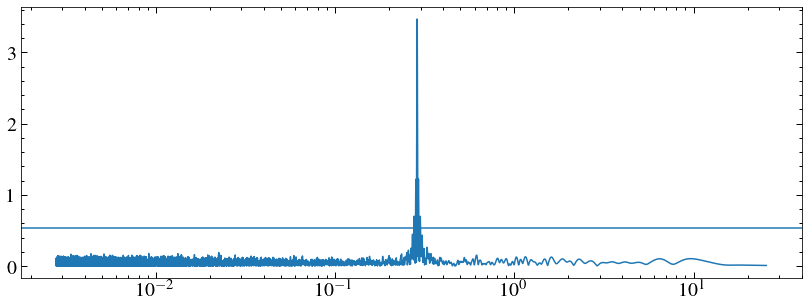

In [22]:
plt.plot(pg1.period, pg1.power)
plt.xscale('log')
plt.axhline(fa99)

So no short period :( make fancy plot. Find ephemeris properly?

2144.4623509128496
2157.206063856891
2157.2348962443575
2157.148218736583
Parameter('phase', value=1.2982676739155343) 0.4947485859182388
2459157.1482187365


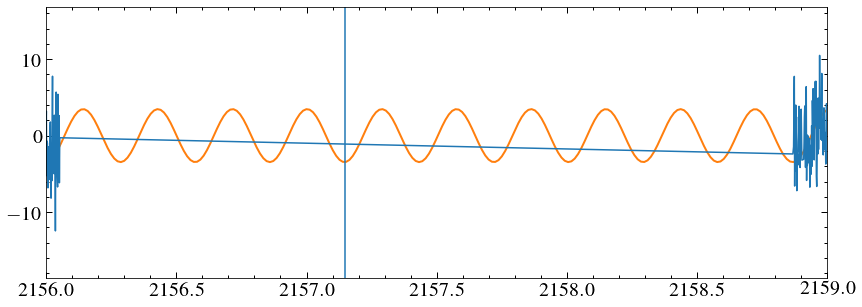

In [23]:
t0 = lc1.time[0] + (1/sin_fit.frequency)*(fold_fit.phase) #0.5 = inferior conjunction
print(t0)
tmid = np.mean(lc1.time)
print(tmid)
tmid2 = lc1.time[0] + (0.5 * (lc1.time[-1] - lc1.time[0]))
print(tmid2)
eph = t0 + np.mean(lc1.time)- lc1.time[0]
print(eph)

plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
plt.xlim(2156, 2159)
plt.axvline(eph)
#plt.axvline(tmid)
print(sin_fit.phase, sin_fit_e[2])
plt.plot(lc1.time, lc1.flux)

print(eph+2457000)

<ErrorbarContainer object of 3 artists>

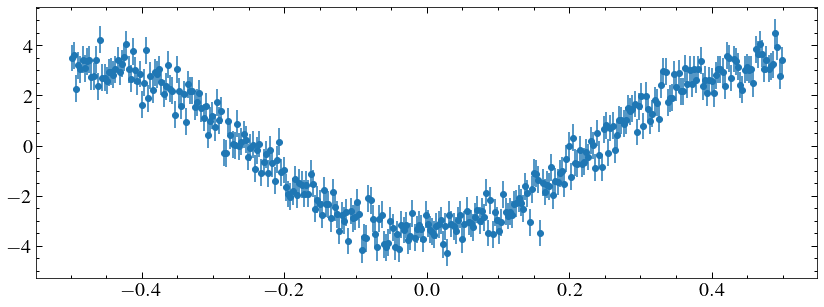

In [24]:
lcf = lc1.fold(1/sin_fit.frequency.value, t0=eph).bin(50)
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o')


In [25]:
#fits.getheader(lcpath, 1)

Final results  
Period = 6.88180 +/- 0.00045 h  
Amplitude = 3.464 +/- 0.039 %  
Ephemeris = 2459157.14821 0.00051   
Nice plot:

0.048887945624293515 %
0.026038696582869354 %


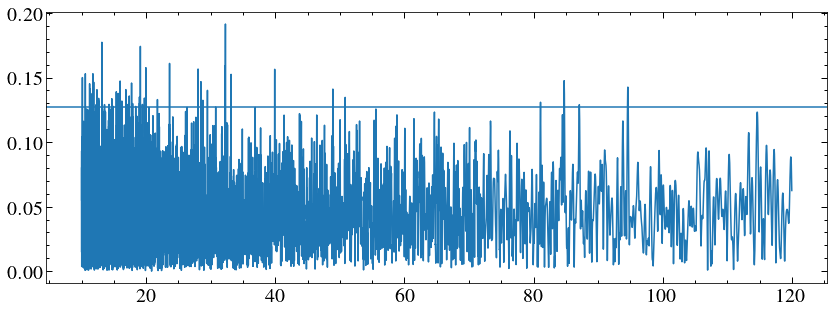

(array([7.210e+02, 1.902e+03, 2.882e+03, 3.571e+03, 3.910e+03, 3.874e+03,
        3.631e+03, 3.241e+03, 2.726e+03, 2.268e+03, 1.591e+03, 1.159e+03,
        7.610e+02, 4.740e+02, 3.280e+02, 2.000e+02, 1.420e+02, 7.000e+01,
        4.600e+01, 3.600e+01, 1.700e+01, 5.000e+00, 6.000e+00, 3.000e+00,
        3.000e+00]),
 array([4.97757377e-05, 7.70512638e-03, 1.53604770e-02, 2.30158277e-02,
        3.06711783e-02, 3.83265290e-02, 4.59818796e-02, 5.36372302e-02,
        6.12925809e-02, 6.89479315e-02, 7.66032822e-02, 8.42586328e-02,
        9.19139835e-02, 9.95693341e-02, 1.07224685e-01, 1.14880035e-01,
        1.22535386e-01, 1.30190737e-01, 1.37846087e-01, 1.45501438e-01,
        1.53156789e-01, 1.60812139e-01, 1.68467490e-01, 1.76122841e-01,
        1.83778191e-01, 1.91433542e-01]),
 <BarContainer object of 25 artists>)

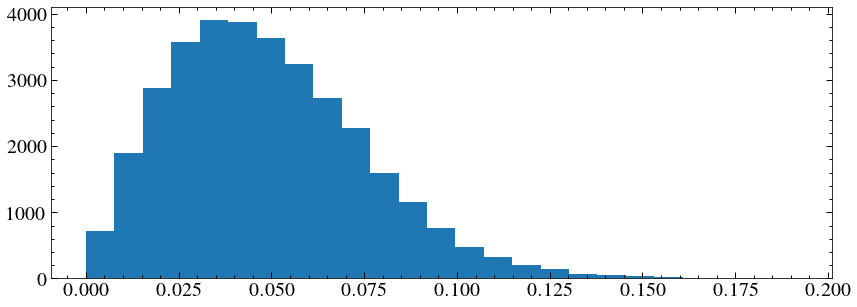

In [26]:
#rule out short periods.

pg1m = pg1.period.to(u.min)
pg1h = pg1.period.to(u.h)
mask = (pg1m > 10*u.min) & (pg1m < 120*u.min)
plt.plot(pg1m[mask], pg1.power[mask])
mean, std = np.mean(pg1.power[mask]).value, np.std(pg1.power[mask]).value
print(np.mean(pg1.power[mask]))
print(np.std(pg1.power[mask]))
plt.axhline(mean+3*std)
plt.show()
plt.hist(pg1.power[mask].value, bins=25)

In [27]:
b = 5
oc = lc1.bin(b).flux-sin_fit(lc1.bin(b).time)
print(np.mean(oc))
print(np.std(oc))

0.027277139175939626
1.594530937109243


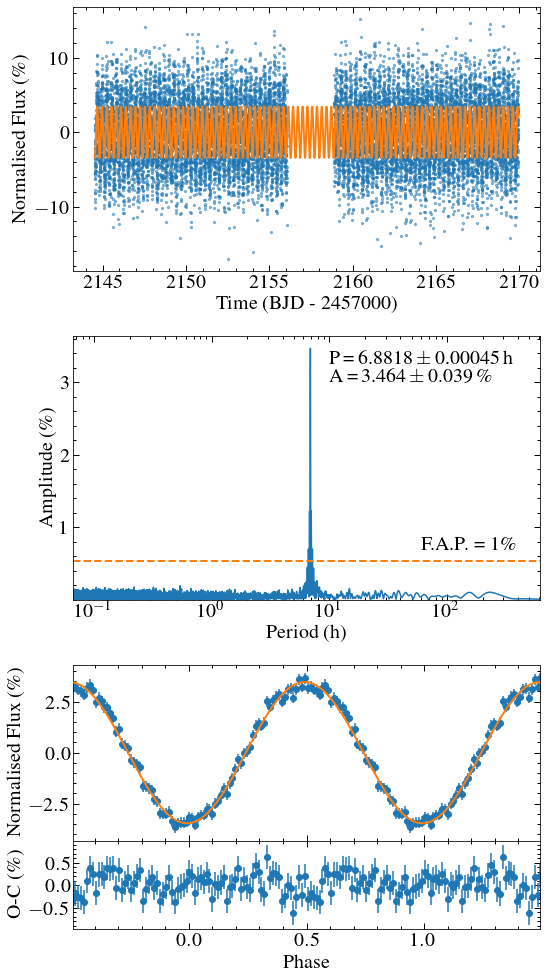

In [28]:
# fig,  (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 15))
plt.figure(figsize=(8, 14))
gs = GridSpec(3, 1)
plt.subplot(gs[1, :])
plt.plot(pg1h, pg1.power)
plt.xscale('log')
plt.axhline(fa99, c='C1', ls='--', lw=2)

plt.xlim(pg1h.value[-1], pg1h[0].value)
plt.ylim(0.0001)
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
#axins = inset_axes(ax, width='40%', height='30%', loc=2)
#axins.plot(pg1m[mask], pg1.power[mask])
plt.annotate('P\,=\,{0}\,$\pm$\,{1}\,h \n A\,=\,{2}\,$\pm$\,{3}\,\%'.format(6.88180,0.00045, 3.464,  0.039), (10, 3.), xycoords='data')
plt.annotate('F.A.P. = 1\%', (0.95, fa99+0.1), xycoords=('axes fraction', 'data'), ha='right', va='bottom')

plt.subplot(gs[0, :])


plt.scatter(lc1.time, lc1.flux, s=5, rasterized=True, alpha=0.5) 
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 




plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)

gs1 = gs[2].subgridspec(3, 1, hspace=0)
plt.subplot(gs1[:2, :])
lcf = lc1.fold(1/sin_fit.frequency.value, t0=eph).bin(200)

lcf_mod =  models.Sine1D(amplitude=fold_fit.amplitude, frequency= 1, phase=0, fixed={'amplitude': True, 'frequency':True})
lcf_fit = fitter(lcf_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
#two cycles
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time, lcf_fit(fold_time), c='C1', lw=2, zorder=10)
plt.errorbar(lcf.time+1, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time+1, lcf_fit(fold_time), c='C1', lw=2, zorder=10)

plt.ylabel('Normalised Flux (\%)', size=20)
plt.xticks(visible=False)

xlims = [-0.49, 1.49] #storing here to update both plots at once
plt.xlim(xlims[0], xlims[1])

plt.subplot(gs1[2:, :])
mod = lcf_fit(lcf.time)
plt.errorbar(lcf.time, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.errorbar(lcf.time+1, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.xlim(xlims[0], xlims[1])
plt.ylabel('O-C (\%)', size=20)

plt.xlabel('Phase', size=20)
plt.tight_layout()
#plt.subplots_adjust(hspace=0.18)
# ax.subplots_adjust(hspace=0.7)
#ax1.set_top=0.99
#ax.set_bottom=0.01
#plt.savefig('plots/cc_cet_tess_30s.pdf', dpi=150)

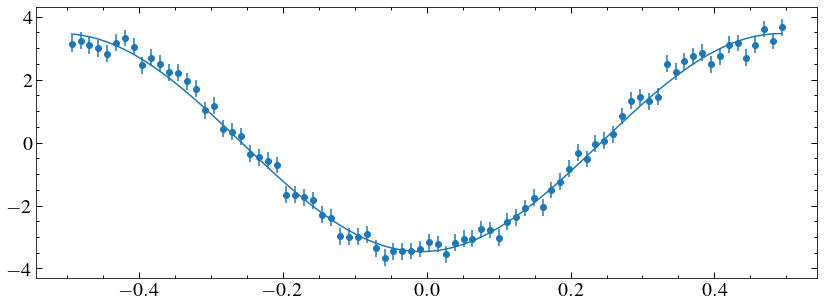

In [29]:
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(lcf.time, mod)

In [30]:
np.std(lcf.flux-mod)

0.23594227914789379

No flares? AD test to do a quick check?

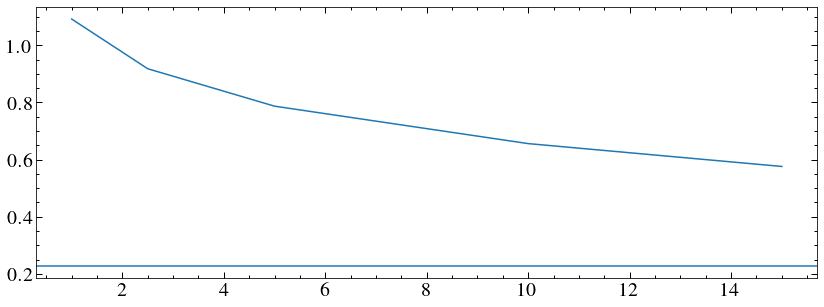

In [31]:
from scipy.stats import anderson
ad = anderson(lc1.flux-sin_fit(lc1.time))
plt.plot(ad.significance_level, ad.critical_values)
plt.axhline(ad.statistic)

Ok AD test failed dramatically? Plot segments in big plot?

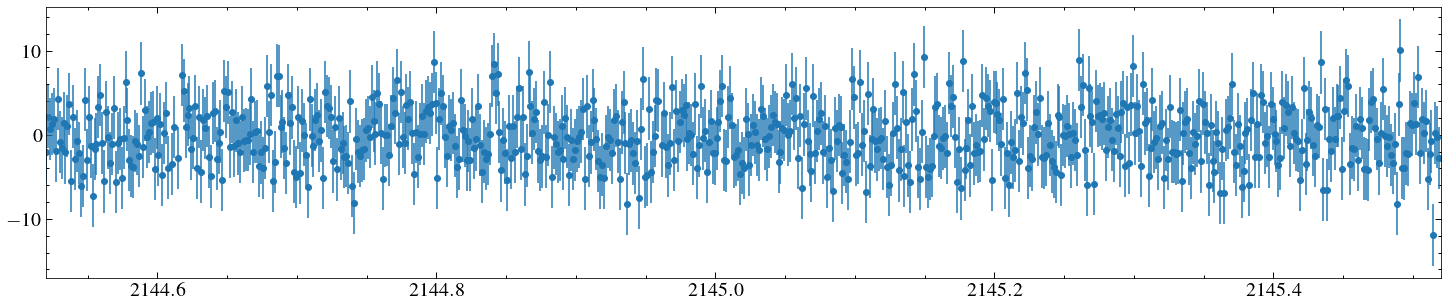

Pass


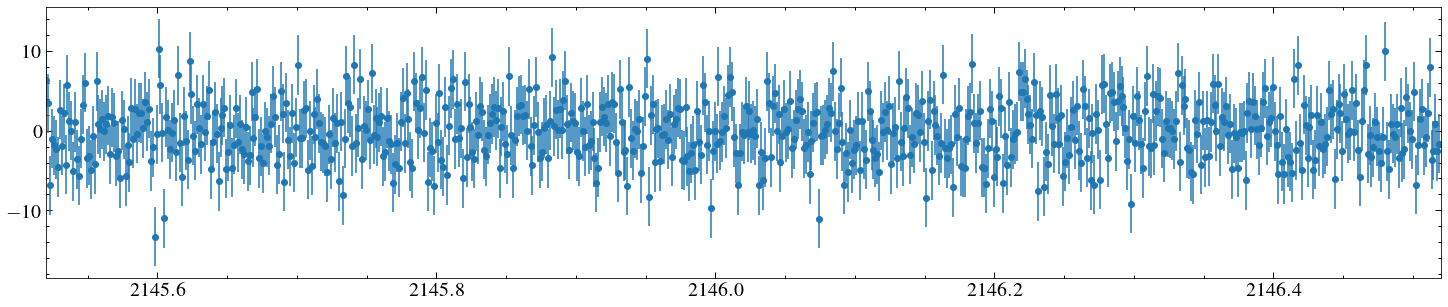

Pass


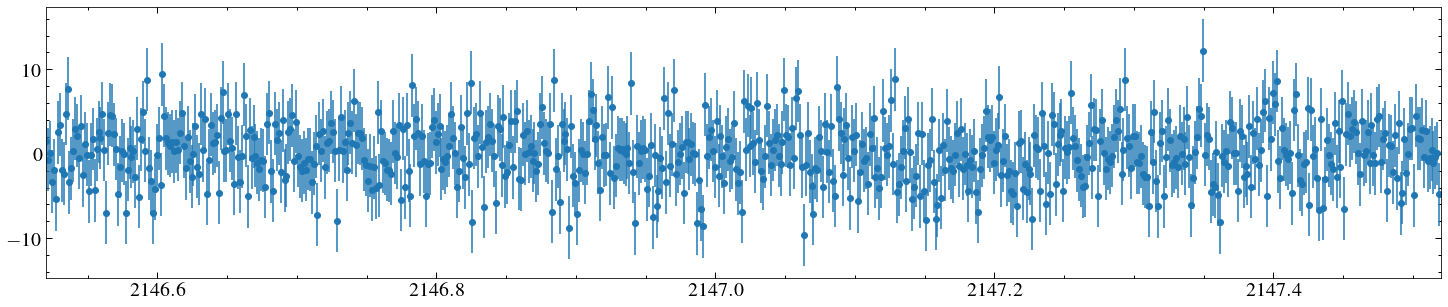

Pass


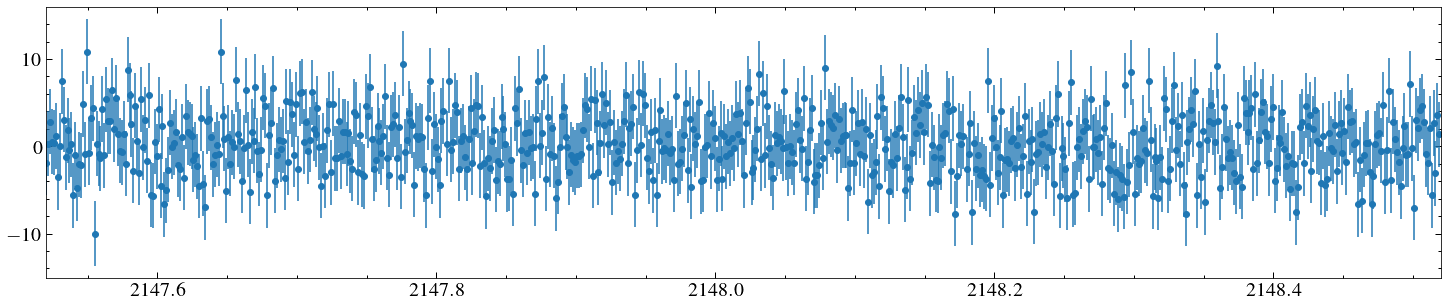

Pass


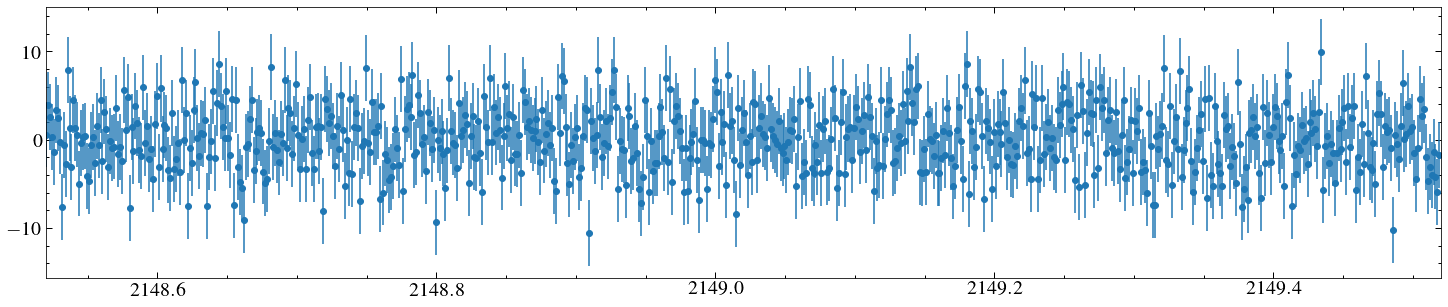

Pass


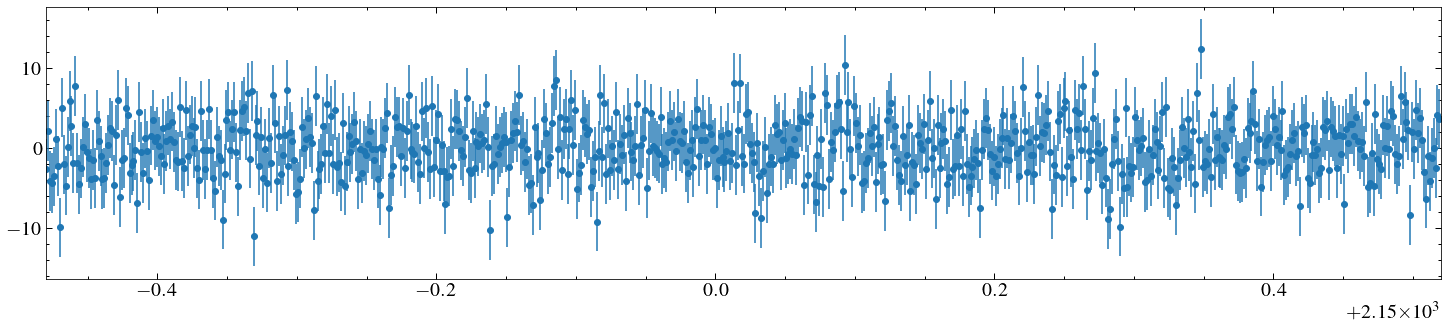

Pass


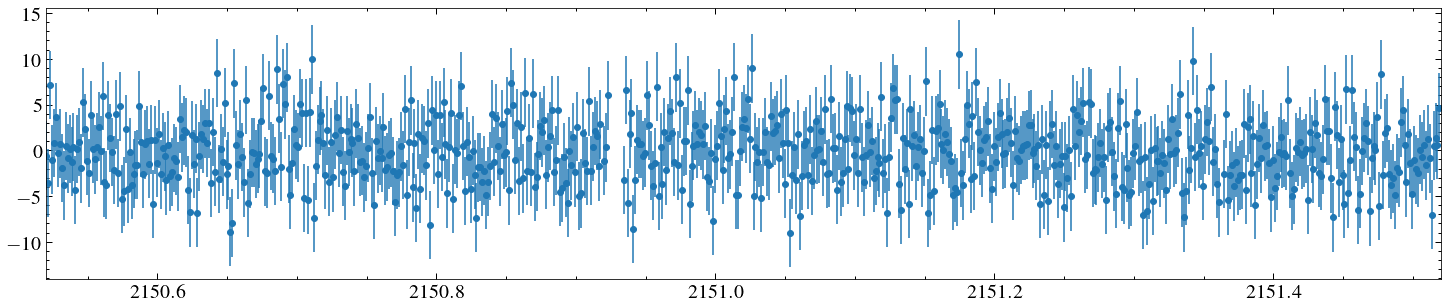

Pass


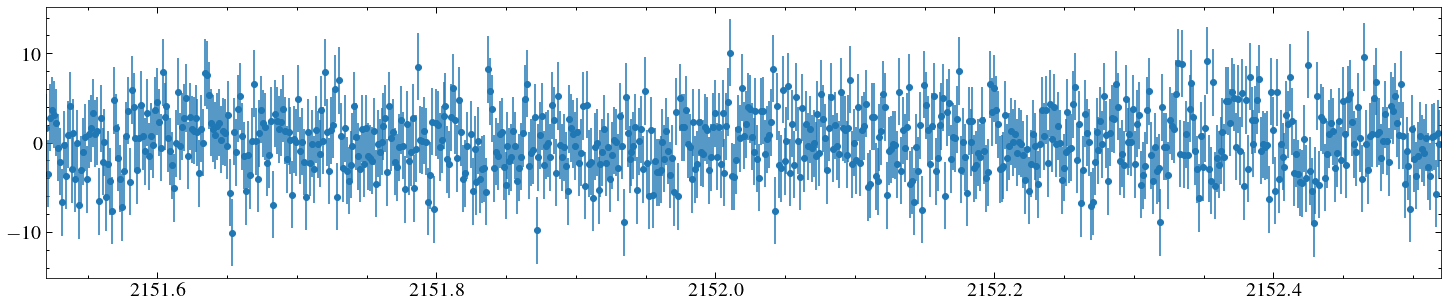

Pass


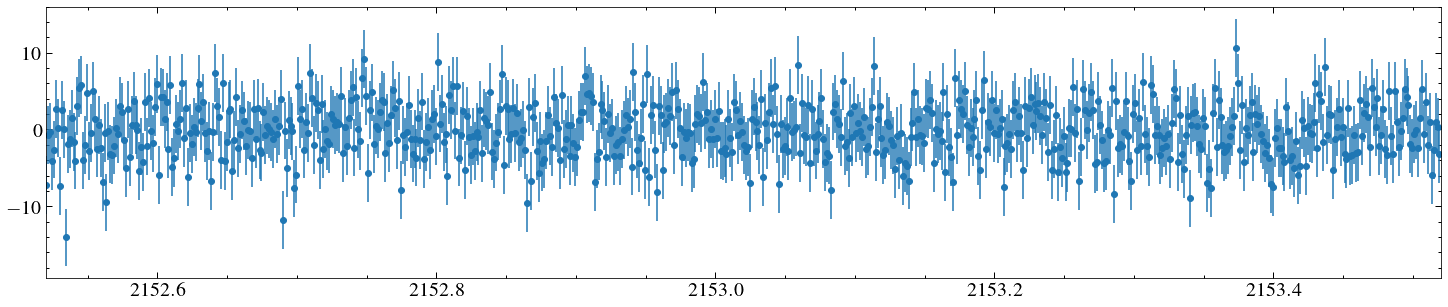

Pass


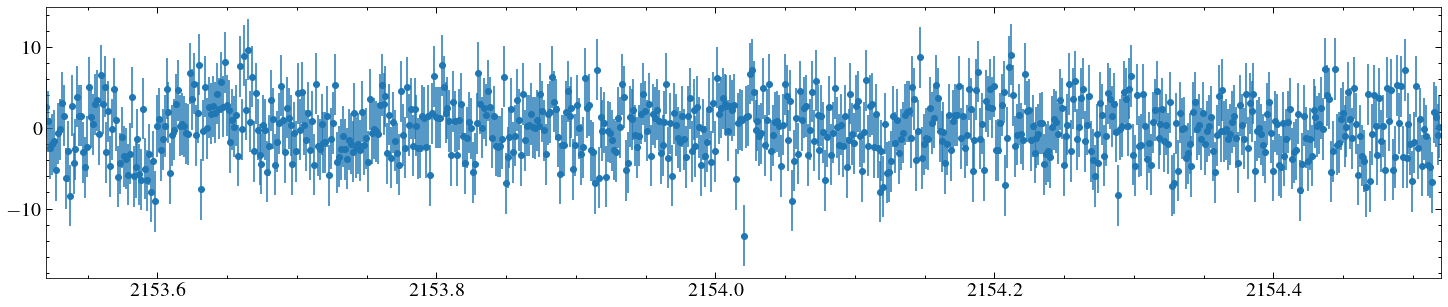

Pass


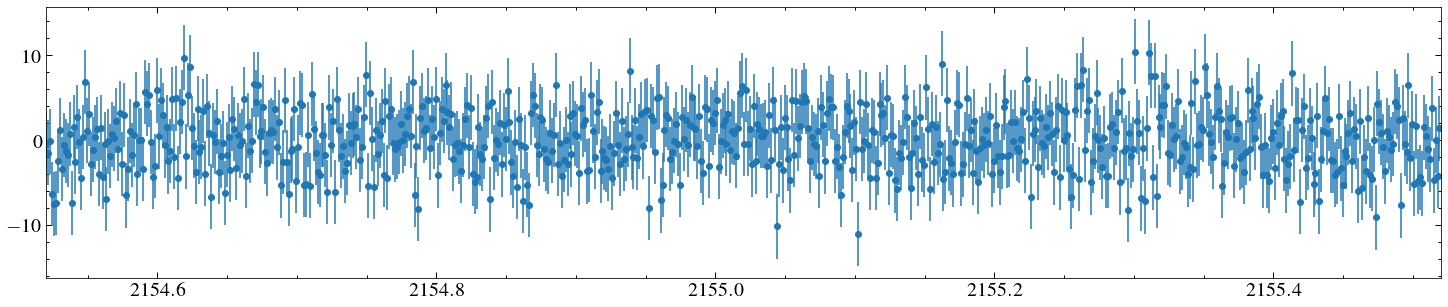

Pass


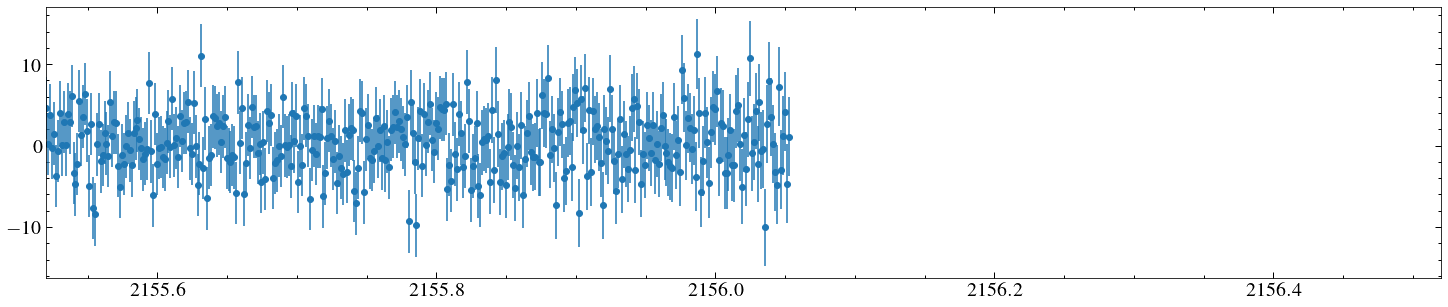

Pass


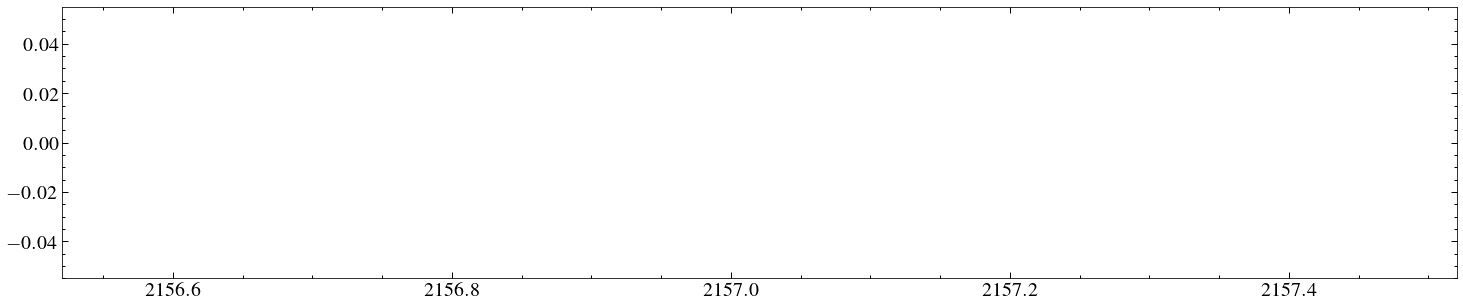

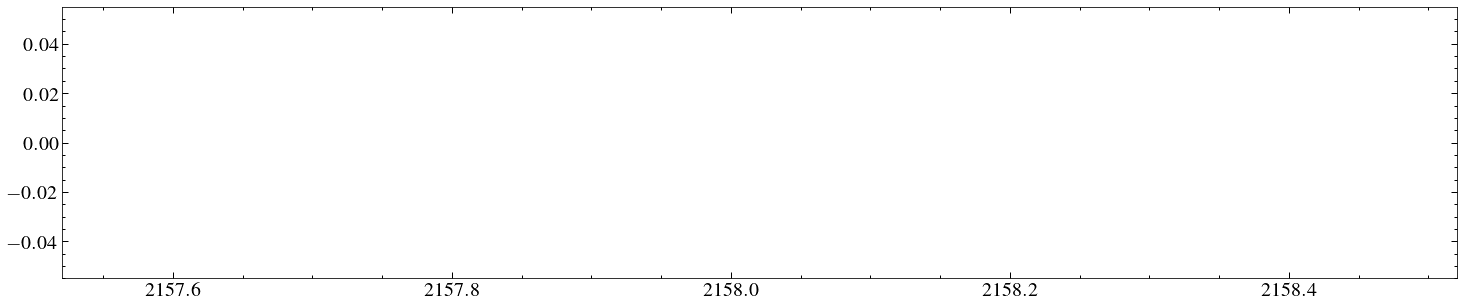

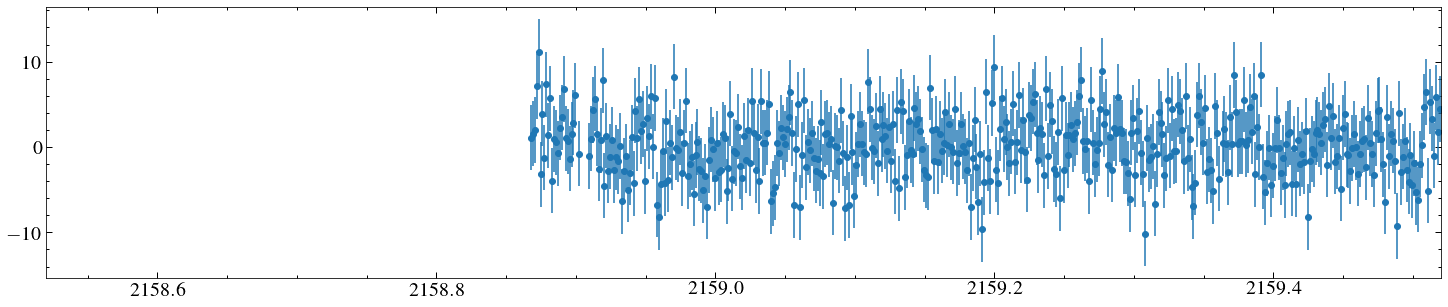

Pass


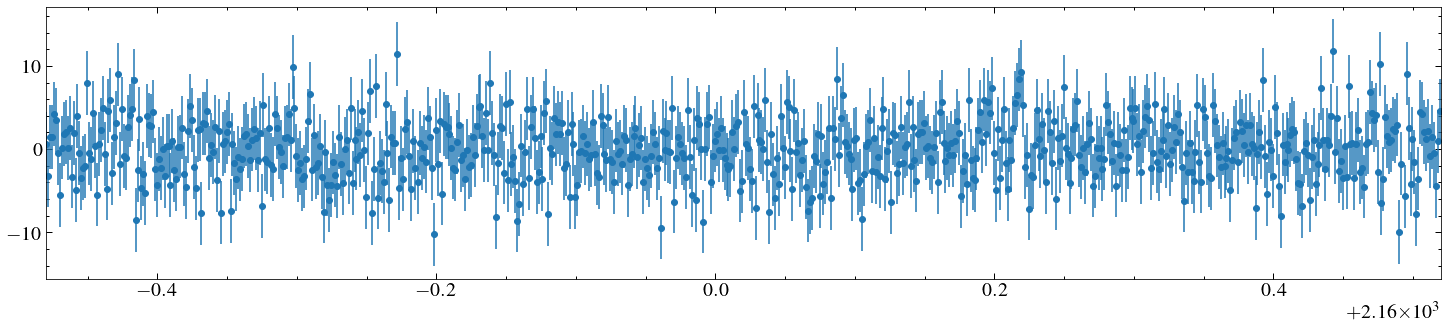

Pass


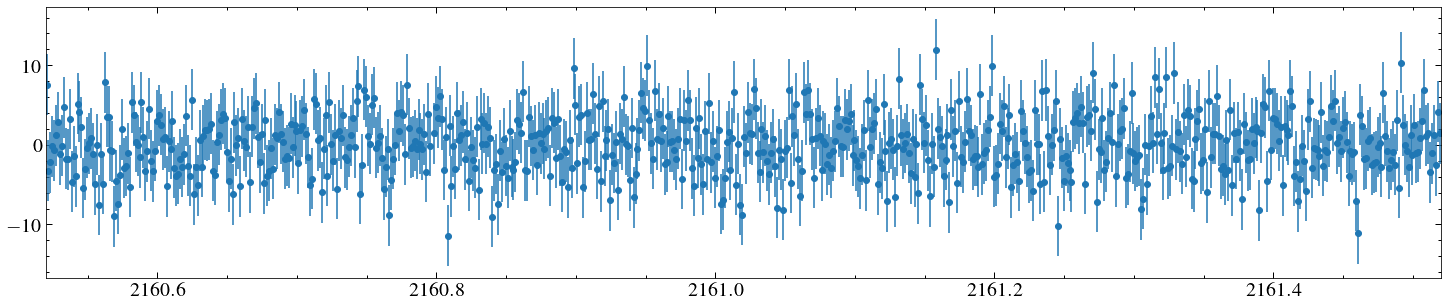

Pass


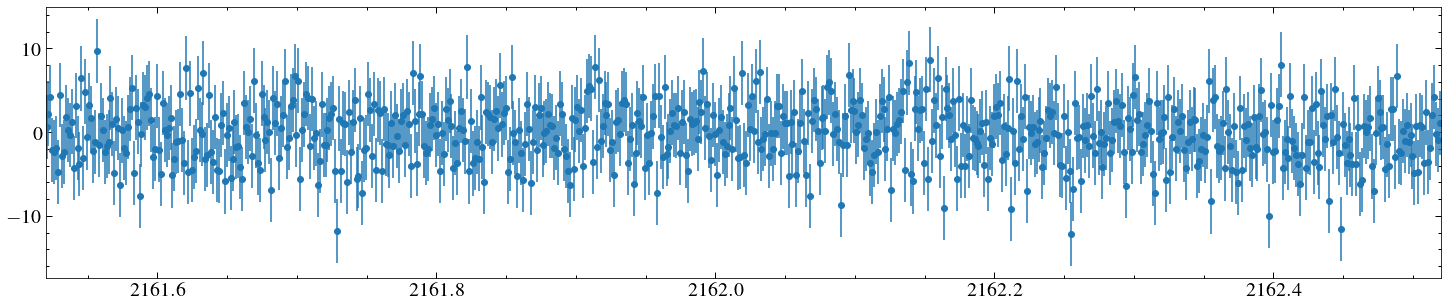

Pass


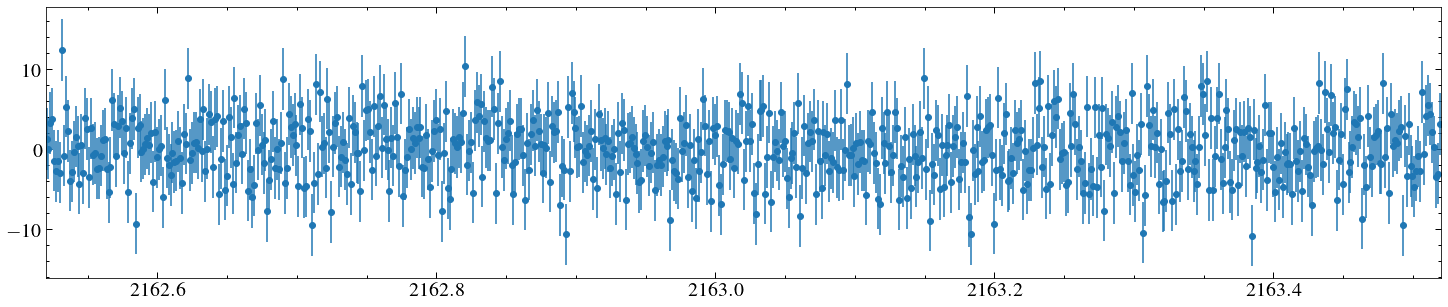

Pass


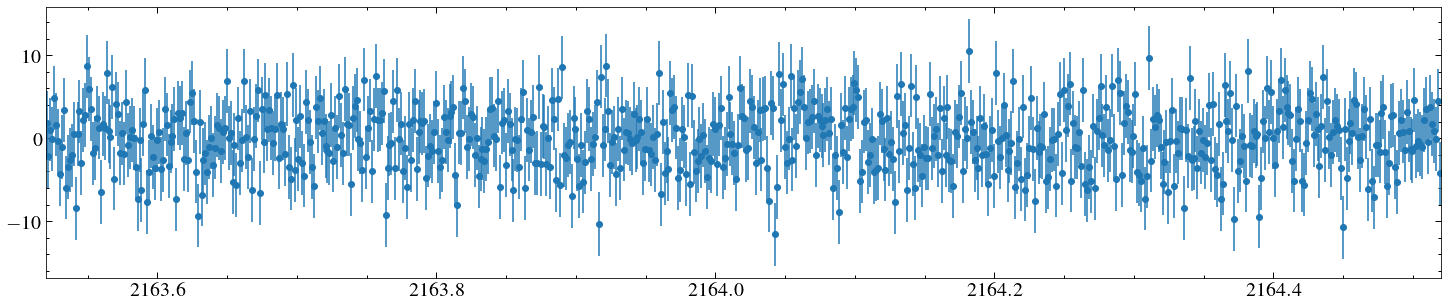

Pass


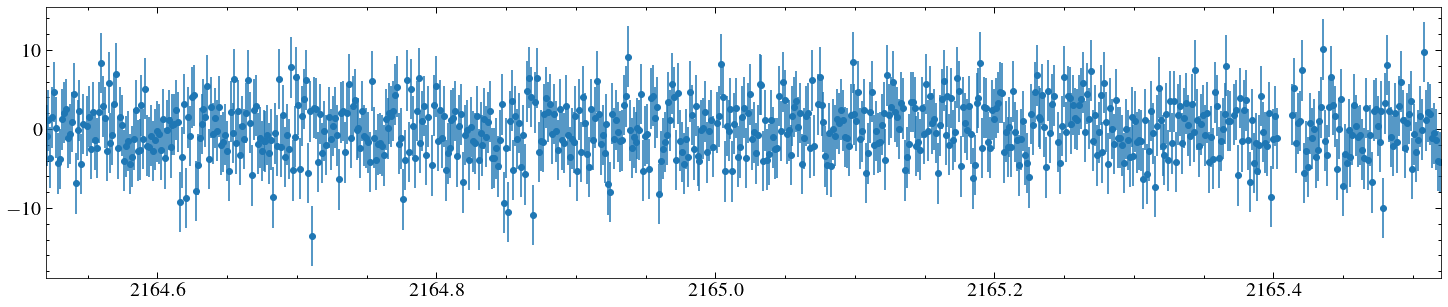

Pass


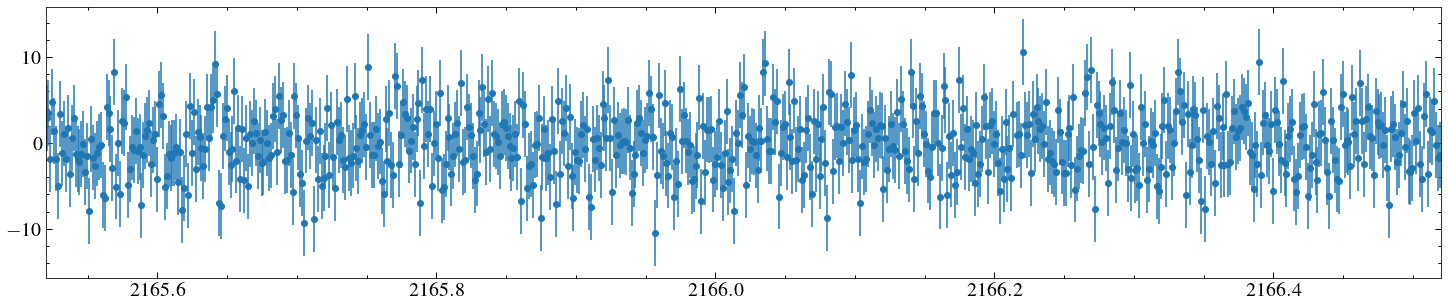

Pass


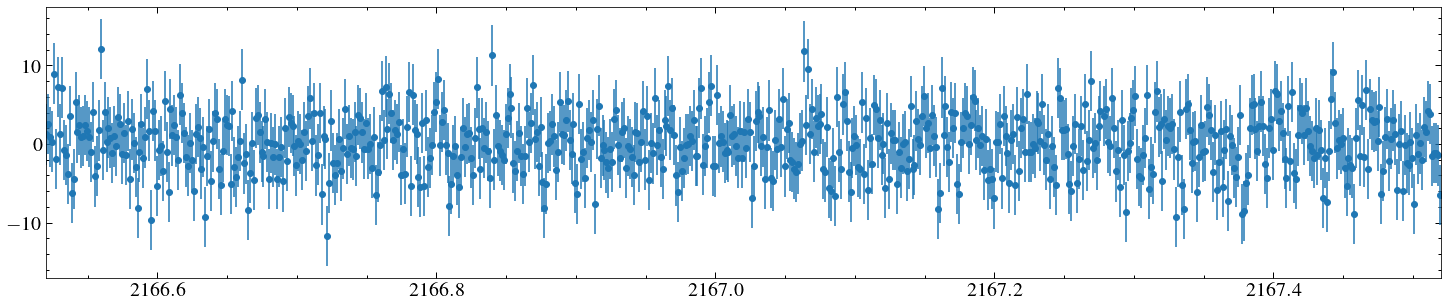

Pass


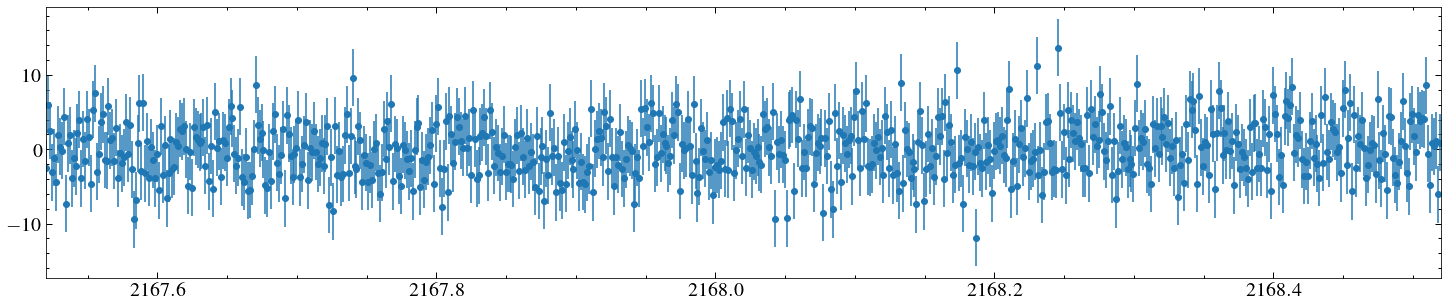

Pass


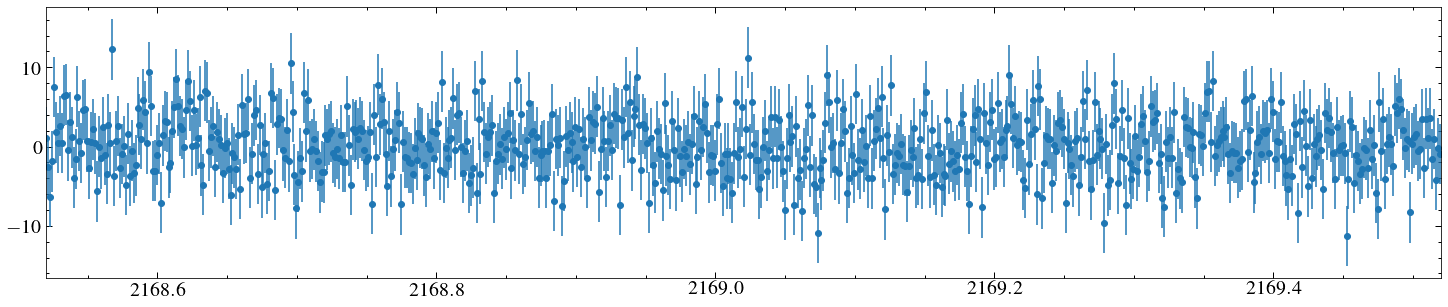

Pass


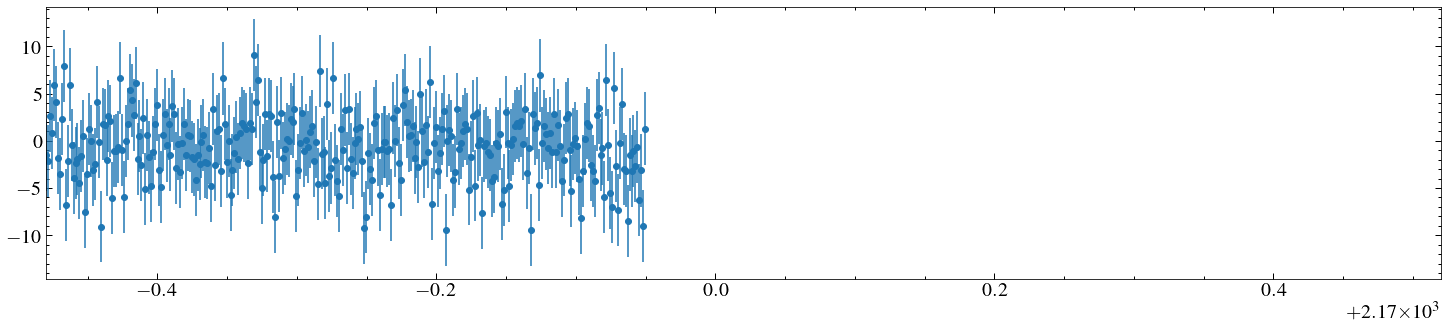

Pass


In [32]:
chunks = np.arange(0, 27)
tstart = lc1.time[0]
sig = 3
for i in range(len(chunks)-1):
    plt.figure(figsize=(25, 5))
    mask = (lc1.time >= tstart+chunks[i]) & (lc1.time < tstart+chunks[i+1])
    plt.errorbar(lc1.time[mask], lc1.flux[mask]-sin_fit(lc1.time[mask]), lc1.flux_err[mask], marker='o', c='C0', ls='none')
   # mask = (lc1.remove_outliers(sigma=sig).time >= tstart+chunks[i]) & (lc1.remove_outliers(sigma=sig).time < tstart+chunks[i+1])
   # plt.errorbar(lc1.remove_outliers(sigma=sig).time[mask], lc1.remove_outliers(sigma=sig).flux[mask], lc1.remove_outliers(sigma=sig).flux_err[mask], marker='o', c='C0')
    plt.xlim(tstart+chunks[i],tstart+chunks[i+1])
    plt.show()
    if len(lc1.time[mask]) >0:
        ad = anderson(lc1.flux[mask]-sin_fit(lc1.time[mask]))
        if ad.statistic < max(ad.critical_values):
            print('Pass')
        else:
            print('Fail')
    

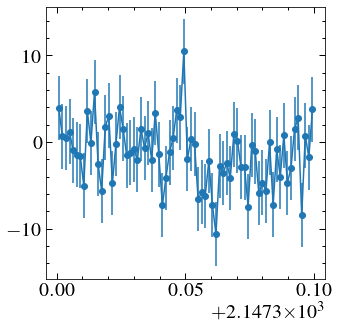

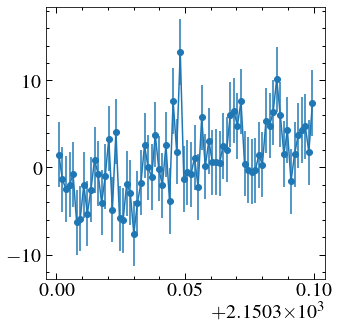

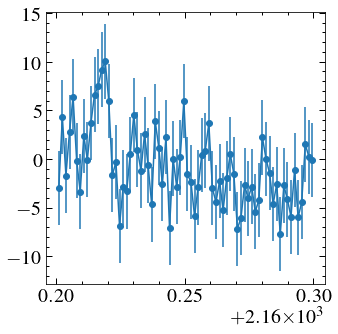

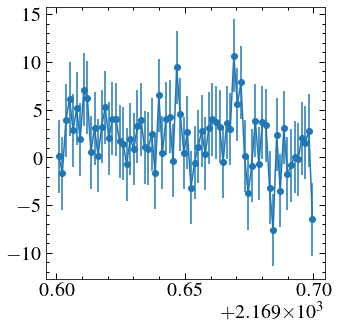

In [33]:
flare_can = [2147.3, 2150.3, 2160.2, 2169.6]
for can in flare_can:
    plt.figure(figsize=(5, 5))
    mask = (lc1.time >= can) & (lc1.time < can+0.1)
    plt.errorbar(lc1.time[mask], lc1.flux[mask], lc1.flux_err[mask], marker='o')
   # plt.xlim(tstart+chunks[i],tstart+chunks[i+1])
    plt.show()

There's also 20s data available?

In [34]:
path20 = '/media/david/5tb_storage1/cc_cet/tess/MAST_2021-01-01T1635/TESS/tess2020294194027-s0031-0000000337219837-0198-a_fast/'
lcpath20 = glob.glob('{}*lc.fits'.format(path20))[0]
lcpath20

'/media/david/5tb_storage1/cc_cet/tess/MAST_2021-01-01T1635/TESS/tess2020294194027-s0031-0000000337219837-0198-a_fast/tess2020294194027-s0031-0000000337219837-0198-a_fast-lc.fits'

In [35]:
data20 = fits.getdata(lcpath20,1)
t, f, e, q, bk = data20['TIME'], data20['PDCSAP_FLUX'], data20['PDCSAP_FLUX_ERR'], data20['QUALITY'], data20['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
#fit = np.polyval((np.polyfit(t,f,2)), t)
#f = (f/fit)-1
#e = (e/fit)
#cut_mask = (bk < 1.1*np.median(bk))
lc20 = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_nans()#.remove_outliers(sigma=5)

<AxesSubplot:xlabel='Time', ylabel='Flux'>

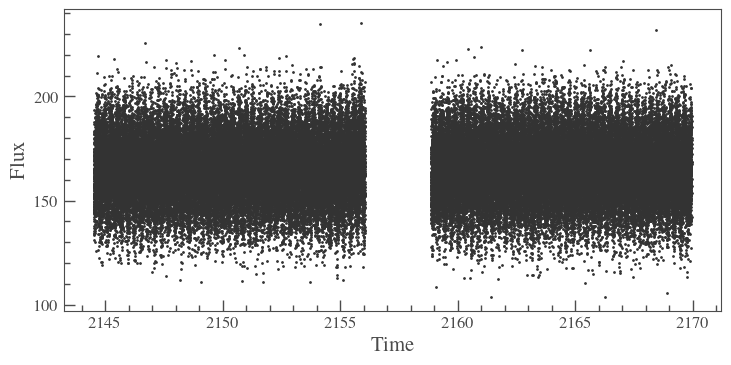

In [36]:
lc20.scatter()

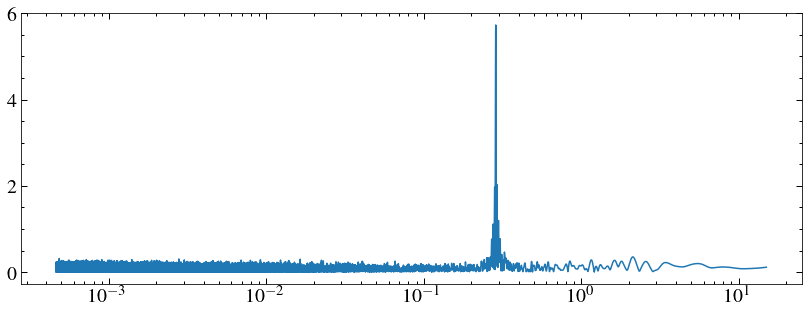

In [37]:
pg20 = lc20.to_periodogram(oversample_factor=10,minimum_period=40*u.second, maximum_period=15*u.day)
plt.plot(pg20.period, pg20.power)
plt.xscale('log')

(2145.0, 2146.0)

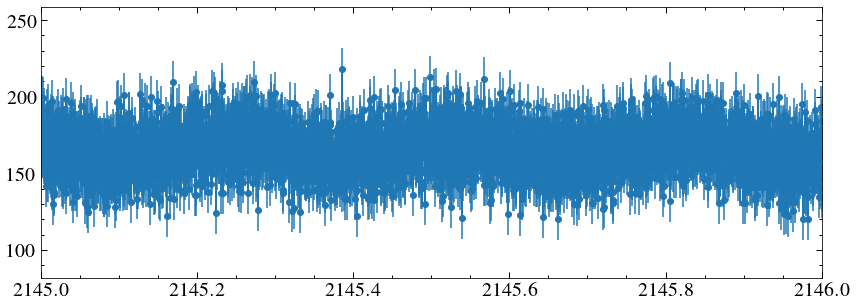

In [38]:
plt.errorbar(lc20.time, lc20.flux, yerr=lc20.flux_err, marker='o')
plt.xlim(2145, 2146)

In [39]:
#lk.search_lightcurvefile('CC Cet')

<AxesSubplot:xlabel='Time', ylabel='Flux [$\\mathrm{\\%}$]'>

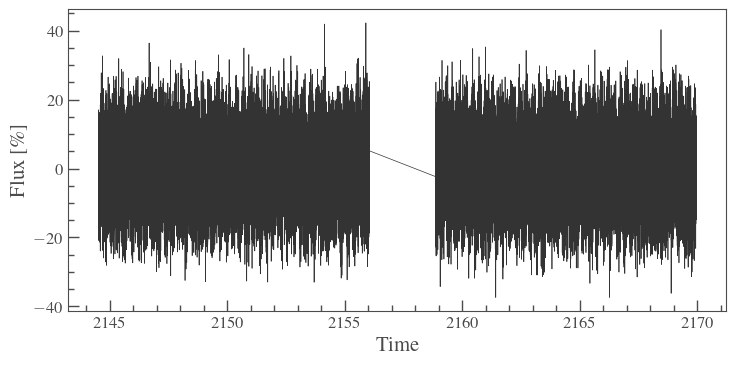

In [40]:
lc20n = lc20.normalize(unit='percent')
lc20n.flux -=100
lc20n.plot()

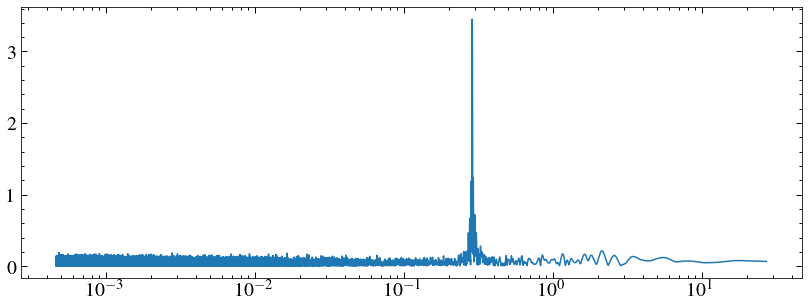

In [41]:
pg20n = lc20n.to_periodogram(oversample_factor=10,minimum_period=40*u.second, maximum_period=27*u.day)
plt.plot(pg20n.period, pg20n.power)
plt.xscale('log')

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude         frequency            phase       
    ----------------- ----------------- -------------------
    3.461359343865537 3.487192786458597 -3.6348506628739554
[3.91384333e-02 2.31127069e-04 4.98551883e-01]
Period = 6.882326693607637 0.0004561525821496103 h
Amplitude = 3.461359343865537 0.039138433271143774
Phase = -3.6348506628739554 0.4985518834166894


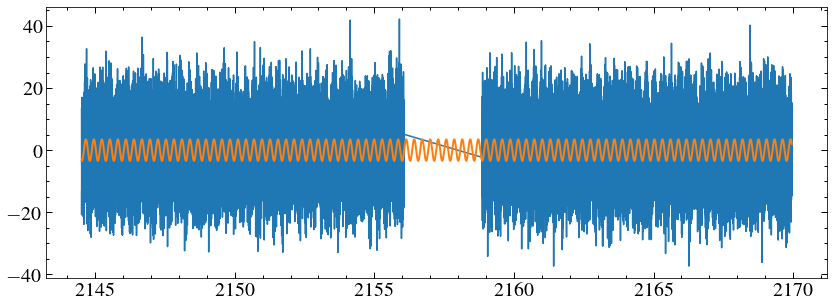

2143.405583499215
Amplitude = -3.4613593519684556 0.039138214912684814
Phase = -0.1348506020727974 0.0018031782841737923
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude      frequency        phase       
    ------------------- --------- -------------------
    -3.4613593519684556       1.0 -0.1348506020727974
[0.03913821 0.00180318]


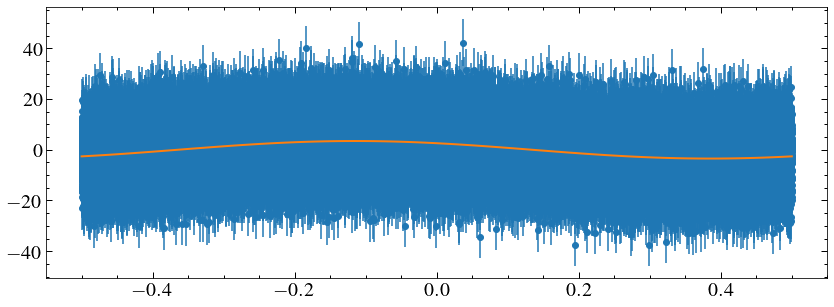

In [42]:


sin_mod =  models.Sine1D(amplitude=pg20n.max_power.value, frequency= pg20n.frequency_at_max_power.value, phase=0)#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
sin_fit = fitter(sin_mod, lc20n.time, lc20n.flux, weights = 1/lc20n.flux_err, maxiter=100000)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc20n.time, lc20n.flux) 
timefit = np.linspace(lc20n.time[0], lc20n.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print(sin_fit)
print(sin_fit_e)
print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
print('Phase =', sin_fit.phase.value, sin_fit_e[2])
plt.show()

t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.25)
print(t0)
lcf = lc20n.fold(1/sin_fit.frequency.value)
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o')
fold_mod =  models.Sine1D(amplitude=pg1.max_power.value, frequency= 1, phase=0, fixed={'frequency':True})#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
fold_fit = fitter(fold_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
fold_time = np.linspace(-0.5, 0.5, 100)
plt.plot(fold_time, fold_fit(fold_time), c='C1', lw=2, zorder=10)

print('Amplitude =', fold_fit.amplitude.value, fold_fit_e[0])
print('Phase =', fold_fit.phase.value, fold_fit_e[1])
print(fold_fit)
print(fold_fit_e)

20s data shows nothing new.

In [43]:
fits.getheader(lcpath, 0)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-12-12'         / file creation date.                            
TSTART  =    2144.519501678684 / observation start time in BTJD                 
TSTOP   =    2169.950290773249 / observation stop time in BTJD                  
DATE-OBS= '2020-10-22T00:26:

In [44]:
fits.getheader(lcpath20, 0)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-12-10'         / file creation date.                            
TSTART  =    2144.519501679150 / observation start time in BTJD                 
TSTOP   =    2169.951216685732 / observation stop time in BTJD                  
DATE-OBS= '2020-10-22T00:26:

Checked if SAP light curve changed the periodogram - No.

In [45]:
# new fap for 20s with errors
"""
n = 10000
#peak_collections = []
check = np.arange(500, n+1, 500)
i = 0
max_peak = []
# max_peak_e = [] 
print(datetime.now().time())
while i < n:
    i+=1
    
    indices = np.random.choice(len(lc20n.time), size=(len(lc20n.time)))
    fake_lc1 = lk.LightCurve(time=lc20n.time, flux=lc20n.flux[indices])
    fake_pg1 = fake_lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak.append(max(fake_pg1.power).value)
   # fake_lc2 = lk.LightCurve(time=lc20n.time, flux=lc20n.flux[indices], flux_err=lc20n.flux_err[indices])
   # fake_pg2 = fake_lc2.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
   # max_peak_e.append(max(fake_pg2.power).value)
    if i in check:
        print(i)
        print(datetime.now().time())
#peak_collections.append(max_peak)
np.save('fake_peaks5', np.array(max_peak))
#np.save('fake_peaks6', np.array(max_peak_e))
print(datetime.now().time())"""

13:08:42.936001
500
13:19:14.483234
1000
13:30:05.771730
1500
13:49:51.251462
2000
14:07:37.619690
2500
14:19:35.644968
3000
14:32:07.899735
3500
14:43:33.901522
4000
14:54:55.130410
4500
15:06:23.332862
5000
15:17:00.231404
5500
15:27:02.144607
6000
15:37:16.712112
6500
15:48:42.856998
7000
16:00:13.514941
7500
16:10:27.803251
8000
16:21:25.538170
8500
16:32:34.883662
9000
16:44:01.330342
9500
16:55:11.535479
10000
17:05:57.679322
17:05:57.680912


In [46]:
fake_peaks = np.load('fake_peaks5.npy')
fa99 = np.percentile(fake_peaks, 99.9)
print(fa99)

# print(fake_peaks)

0.24260854351745784


Oops need to redo down to 30s. Can still redo plot though.

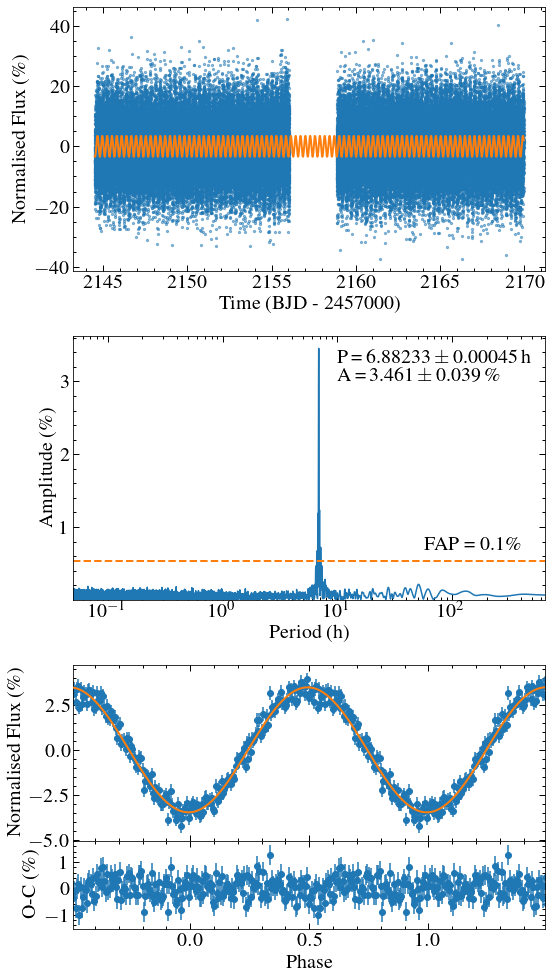

In [57]:
# fig,  (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 15))
plt.figure(figsize=(8, 14))
gs = GridSpec(3, 1)
plt.subplot(gs[1, :])
pg20h = pg20n.period.to(u.hour)
plt.plot(pg20h, pg20n.power)
plt.xscale('log')
plt.axhline(fa99, c='C1', ls='--', lw=2)

plt.xlim(0.05, pg20h[0].value)
plt.ylim(0.0001)
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
#axins = inset_axes(ax, width='40%', height='30%', loc=2)
#axins.plot(pg1m[mask], pg1.power[mask])
plt.annotate('P\,=\,{0}\,$\pm$\,{1}\,h \n A\,=\,{2}\,$\pm$\,{3}\,\%'.format(6.88233,0.00045, 3.461,  0.039), (10, 3.), xycoords='data')
#6.882326693607637 0.0004561525821496103
#-3.4613593519684556 0.039138214912684814

plt.annotate('FAP = 0.1\%', (0.95, fa99+0.1), xycoords=('axes fraction', 'data'), ha='right', va='bottom')

plt.subplot(gs[0, :])


plt.scatter(lc20n.time, lc20n.flux, s=5, rasterized=True, alpha=0.5) 
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 




plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)

gs1 = gs[2].subgridspec(3, 1, hspace=0)
plt.subplot(gs1[:2, :])
lcf = lc20n.fold(1/sin_fit.frequency.value, t0=eph).bin(500)

lcf_mod =  models.Sine1D(amplitude=fold_fit.amplitude, frequency= 1, phase=0, fixed={'amplitude': True, 'frequency':True})
lcf_fit = fitter(lcf_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
#two cycles
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time, lcf_fit(fold_time), c='C1', lw=2, zorder=10)
plt.errorbar(lcf.time+1, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time+1, lcf_fit(fold_time), c='C1', lw=2, zorder=10)

plt.ylabel('Normalised Flux (\%)', size=20)
plt.xticks(visible=False)

xlims = [-0.49, 1.49] #storing here to update both plots at once
plt.xlim(xlims[0], xlims[1])

plt.subplot(gs1[2:, :])
mod = lcf_fit(lcf.time)
plt.errorbar(lcf.time, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.errorbar(lcf.time+1, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.xlim(xlims[0], xlims[1])
plt.ylabel('O-C (\%)', size=20)

plt.xlabel('Phase', size=20)
plt.tight_layout()
#plt.subplots_adjust(hspace=0.18)
# ax.subplots_adjust(hspace=0.7)
#ax1.set_top=0.99
#ax.set_bottom=0.01
plt.savefig('plots/cc_cet_tess_20s.pdf', dpi=150)